In [1]:
# Data: Life Expectancey dataset on Kaggle
# https://www.kaggle.com/kumarajarshi/life-expectancy-who

import pandas as pd
from google.colab import files
import numpy as np

uploaded = files.upload()

Saving Life Expectancy Data.csv to Life Expectancy Data.csv


In [2]:
import io
df = pd.read_csv(io.BytesIO(uploaded['Life Expectancy Data.csv']))

#Clean up column names 
df.rename(columns={' thinness 5-9 years': 'Thinness_5_9_years', ' thinness  1-19 years': 'Thinness_1_19_years', ' BMI ': 'BMI', 'Life expectancy ': 'Life_expectancy', 'Measles ': 'Measles', 'under-five deaths ': 'Under_5_deaths', 'Diphtheria ': 'Diphtheria', ' HIV/AIDS': 'HIV_AIDS', 'percentage expenditure': 'Pct_expenditure', 'infant deaths': 'Infant_deaths', 'Hepatitis B': 'Hep_B', 'Total expenditure': 'Total_expenditure', 'Income composition of resources': 'Incom_comp_rescs', 'Adult Mortality': 'Adult_mortality'}, inplace=True)

In [3]:
# Get rid of columns with lots of null items or other issues 
df.drop(columns=['Hep_B', 'BMI', 'Population', 'Alcohol', 'Total_expenditure'], inplace=True)
# Null values remain in some columns. 

# Replace infinite values (inf) with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Grab columns as list
columns = list(df.columns)

In [4]:
# Obtain dataframes for 2000 and 2015. 

# 2015 dataframe
d2015 = df[df['Year'] == 2015]
d2015.reset_index(drop=True, inplace=True)
    
# 2000 dataframe
d2000 = df[df['Year'] == 2000]
d2000.reset_index(drop=True, inplace=True)

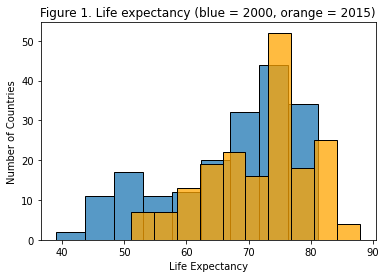

In [5]:
# Plot distribution of life expectancies in 2000 and 2015
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(d2000['Life_expectancy'])
ax = sns.histplot(d2015['Life_expectancy'], color='orange').set_title('Figure 1. Life expectancy (blue = 2000, orange = 2015)')
plt.xlabel('Life Expectancy')
plt.ylabel('Number of Countries')
plt.show()

In [6]:
# Check that both dataframes have the same countries in the same place.
for i in range(len(d2000)):
  if d2000.iloc[i][2] != d2015.iloc[i][2]:
    print(d2015.iloc[i][2])

In [ ]:
# Add column to 2015 dataframe that contains rates of change in Life Expectancy
d2015['Life_exp_rate'] = ((d2015['Life_expectancy'] -  d2000['Life_expectancy']) / d2000['Life_expectancy'] * 100)

In [ ]:
# Add 2000 life expectancy data to 2015 dataframe
d2015['2000_life_exp'] = d2000['Life_expectancy']

In [9]:
# Eliminate negative growth rates
d2015 = d2015[d2015['Life_exp_rate'] >= -1]

# Eliminate huge growth rates
d2015 = d2015[d2015['Life_exp_rate'] < 30]

In [10]:
# Obtain dataframe on countries with less than the median GDP
d2015_poor = d2015[d2015['GDP'] <= d2015['GDP'].median()]

# Put high and low rates in different dataframes
# High rate of growth
d2015_poor_high = d2015_poor[d2015_poor['Life_exp_rate'] > d2015_poor['Life_exp_rate'].median()]
d2015_poor_high.reset_index(drop=True, inplace=True)
# Low rate of growth
d2015_poor_low = d2015_poor[d2015_poor['Life_exp_rate'] <= d2015_poor['Life_exp_rate'].median()]
d2015_poor_low.reset_index(drop=True, inplace=True)

In [11]:
# Independent t-tests
from scipy import stats

p_vals = []
for i in range(3, len(columns)):
  x_var = columns[i]
  A = d2015_poor_high[x_var].dropna()
  B = d2015_poor_low[x_var].dropna()
  tval, pval = stats.ttest_ind(A, B)
  p_vals.append(f'{columns[i]}: {pval}')
  #print(f'{columns[i]}: {round(pval, 4)}')

In [12]:
# Mean values
# Low rate group
means_low = []
for i in range(3, len(columns)):
  mean = round(d2015_poor_low[columns[i]].dropna().mean(), 2)
  means_low.append(f'{columns[i]}: {mean}')
  #print(f'{columns[i]}: {mean}')

# High rate group
means_high = []
for i in range(3, len(columns)):
  mean = round(d2015_poor_high[columns[i]].dropna().mean(), 2)
  means_high.append(f'{columns[i]}: {mean}')
  #print(f'{columns[i]}: {mean}')

In [ ]:
# Perform linear regression, obtain high R2 values
from statsmodels.formula.api import ols

y = 'Life_expectancy'
r_squared = []
high_r_squared = []

for i in range(3, len(columns)):
  x_var = columns[i]
  d2015_poor_nonull = d2015_poor.dropna(subset=[x_var])
  model = ols(f'{y} ~ {x_var}', data=d2015_poor_nonull).fit()
  r_squared.append(f'{columns[i]}: {round(model.rsquared, 4)}')
  if model.rsquared > 0.2:
    high_r_squared.append(f'{columns[i]}: {round(model.rsquared, 4)}')

In [ ]:
# Linear relationship: Life_expectancy - Adult_mortality

x_var = 'Adult_mortality'
y_var = 'Life_expectancy'

# Remove outliers from Adult_mortality
modified = d2015_poor[d2015_poor[x_var] >35]

# Plot relationship
sns.regplot(x=x_var, y=y_var, data=modified.dropna(subset=[x_var, y_var]))

# Fit model with modified dataframe
model = ols(f'{y_var} ~ {x_var}', data=d2015_poor.dropna(subset=[x_var, y_var])).fit()
print(model.summary())

In [ ]:
# Linear relationship: Life_expectancy - Schooling

x_var = 'Schooling'
y_var = 'Life_expectancy'

# Plot relationship
sns.regplot(x=x_var, y=y_var, data=d2015_poor.dropna(subset=[x_var, y_var]))

# Fit model 
model = ols(f'{y_var} ~ {x_var}', data=d2015_poor.dropna(subset=[x_var, y_var])).fit()
print(model.summary())

In [ ]:
# Multiple linear relationship: Life_expectancy ~ Adult_mortality + Schooling

d2015_poor['School_hue'] = pd.cut(d2015_poor.Schooling, bins=[4,11,19], labels=['4-11 yrs', '12-19 yrs'])

x1_var = 'Adult_mortality'
x2_var = 'Schooling'
y_var = 'Life_expectancy'


# Remove outliers from Adult_mortality
modified = d2015_poor[d2015_poor[x1_var] >35]
modified = modified.dropna(subset=[x1_var, x2_var, y_var])

model = ols(f'{y_var} ~ {x1_var} + {x2_var}', data=modified).fit()
print(model.summary())

In [ ]:
# Plot relationship between life expectancy, adult mortality, schooling
sns.lmplot(x=x1_var, y=y_var, hue='School_hue', data=modified, fit_reg=False, ci=None)
plt.title('Figure 2. Life expectancy, adult mortality and schooling')
plt.xlabel('Adult Mortality (deaths age 15-60 per 1,000 people)')
plt.ylabel('Life Expectancy (years)')
plt.show()

The below is an analysis using the same methods as above, but only on the bottom 25% of countries in GDP per capita (the poor-poor). The results are not discussed in the medium post. 

In [19]:
# Obtain dataframe on POOR countries with less than the median GDP
d2015_poor_poor = d2015_poor[d2015_poor['GDP'] <= d2015_poor['GDP'].median()]

# Put high and low rates in different dataframes
# High rate of growth
d2015_poor_poor_high = d2015_poor_poor[d2015_poor_poor['Life_exp_rate'] > d2015_poor_poor['Life_exp_rate'].median()]
d2015_poor_poor_high.reset_index(drop=True, inplace=True)
# Low rate of growth
d2015_poor_poor_low = d2015_poor_poor[d2015_poor_poor['Life_exp_rate'] <= d2015_poor_poor['Life_exp_rate'].median()]
d2015_poor_poor_low.reset_index(drop=True, inplace=True)

In [ ]:
# Independent t-tests
from scipy import stats

p_vals = []
for i in range(3, len(columns)):
  x_var = columns[i]
  A = d2015_poor_poor_high[x_var].dropna()
  B = d2015_poor_poor_low[x_var].dropna()
  tval, pval = stats.ttest_ind(A, B)
  p_vals.append(f'{columns[i]}: {pval}')
  #print(f'{columns[i]}: {round(pval, 4)}')

In [ ]:
# Mean values
# Poor-low group
means_low = []
for i in range(3, len(columns)):
  mean = round(d2015_poor_poor_low[columns[i]].dropna().mean(), 2)
  means_low.append(f'{columns[i]}: {mean}')
  #print(f'{columns[i]}: {mean}')

print('----------')

# Poor-high group
means_high = []
for i in range(3, len(columns)):
  mean = round(d2015_poor_poor_high[columns[i]].dropna().mean(), 2)
  means_high.append(f'{columns[i]}: {mean}')
  #print(f'{columns[i]}: {mean}')